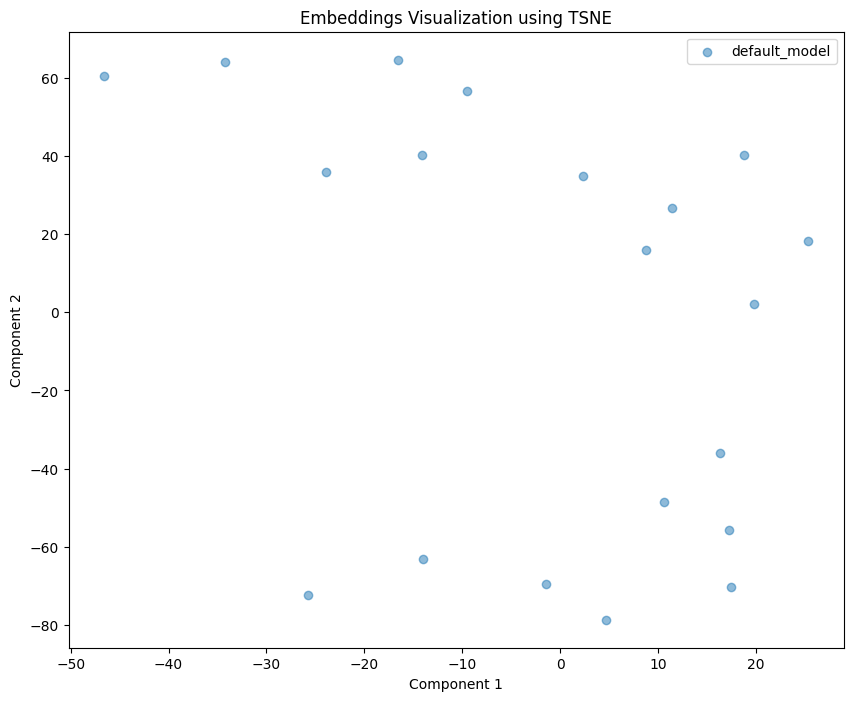

In [4]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def load_embeddings(experiment_name, step):
    step_folder = f"data/{experiment_name}/step_{step}"
    embeddings_file = "/workspace/slice-monorepo/thebeast/chat_pipeline/data/dataforvisualization/step_1/embeddings.json"

    if not os.path.exists(embeddings_file):
        raise FileNotFoundError(f"Embeddings file {embeddings_file} not found.")

    with open(embeddings_file, 'r') as f:
        embeddings = json.load(f)

    return embeddings

def prepare_embeddings(embeddings):
    all_embeddings = []
    labels = []

    for model_name, model_embeddings in embeddings.items():
        all_embeddings.extend(model_embeddings)
        labels.extend([model_name] * len(model_embeddings))

    return np.array(all_embeddings), labels

def visualize_embeddings(embeddings, labels, method='tsne', perplexity=30):
    if method == 'tsne':
        # Adjust the perplexity parameter
        perplexity = min(perplexity, len(embeddings) - 1)
        reducer = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Unsupported method. Use 'tsne' or 'pca'.")

    reduced_embeddings = reducer.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    for i, label in enumerate(set(labels)):
        indices = [j for j, l in enumerate(labels) if l == label]
        plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=label, alpha=0.5)

    plt.legend()
    plt.title(f"Embeddings Visualization using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

if __name__ == "__main__":
    experiment_name = "your_experiment_name"  # Replace with your experiment name
    step = 1  # Replace with the step number you want to visualize

    embeddings = load_embeddings(experiment_name, step)
    all_embeddings, labels = prepare_embeddings(embeddings)
    visualize_embeddings(all_embeddings, labels, method='tsne', perplexity=5)  # Change 'tsne' to 'pca' if you prefer PCA


In [1]:
import openai
import numpy as np
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
import json

client = openai.OpenAI(api_key="sk-proj-7MAfZbOm9lPY28pubTiRT3BlbkFJGgn73o5e6sVCjoTfoFAP")
MODEL = "gpt-4o"

##################################################
def get_full_response(prompt, n=1, max_tokens=1000, temperature=0.7, top_p=1.0, frequency_penalty=0.0, presence_penalty=0.0):
    for _ in range(n):
        response = client.chat.completions.create(
            model="gpt-4o",  # Replace with your model ID as needed
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            frequency_penalty=frequency_penalty,
            presence_penalty=presence_penalty,
            logprobs=True,  # Enable logprobs
            top_logprobs=10  # Specify number of top log probabilities to return
        )

        # Print the entire response object
        return response
        
##################################################
def extract_chat_completion_data(response):
    # Data structure to hold the results
    data = {
        "Response Content": "",
        "Logprobs": [],
        "Top Logprob Words": [],
        "Top Logprob Values": []
    }
    
    # Assume the first choice for simplification; adapt as needed for multiple choices
    if response.choices:
        choice = response.choices[0]
        data["Response Content"] = choice.message.content
        
        # Extract token logprob information
        for token_logprob in choice.logprobs.content:
            # Append the logprob of the current token to the list
            data["Logprobs"].append(token_logprob.logprob)
            
            # For collecting top logprob words and their values
            top_words = []
            top_values = []
            
            # Extract top logprob details
            for top_logprob in token_logprob.top_logprobs:
                top_words.append(top_logprob.token)
                top_values.append(top_logprob.logprob)
            
            # Append each token's top logprob words and values
            data["Top Logprob Words"].append(top_words)
            data["Top Logprob Values"].append(top_values)

    return data

##################################################
def parse_conversations(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    conversations = content.split('\n\n')
    user_messages = []
    chatgpt_messages = []

    current_label = None
    current_message = []

    for conversation in conversations:
        lines = conversation.strip().split('\n')
        if len(lines) >= 1:
            if lines[0] == '#USER':
                if current_label == '##ChatGPT':
                    chatgpt_messages.append(' '.join(current_message))
                current_label = '#USER'
                current_message = lines[1:]
            elif lines[0] == '##ChatGPT':
                if current_label == '#USER':
                    user_messages.append(' '.join(current_message))
                current_label = '##ChatGPT'
                current_message = lines[1:]
            else:
                current_message.extend(lines)

    if current_label == '#USER':
        user_messages.append(' '.join(current_message))
    elif current_label == '##ChatGPT':
        chatgpt_messages.append(' '.join(current_message))

    return user_messages, chatgpt_messages

##################################################
def visualize_2d_grid(encoded_2d_grid, grid_size):
    # Applying Gaussian filter to smooth the grids
    smoothed_grids = np.array([gaussian_filter(grid, sigma=2) for grid in encoded_2d_grid])

    # Setting up the figure and 3D axis
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Creating a meshgrid for the x and y coordinates
    X, Y = np.meshgrid(range(grid_size), range(grid_size))
    
    # Plotting each grid with an increasing offset in Z
    offset = 0.0
    for i in range(smoothed_grids.shape[0]):
        Z = smoothed_grids[i] + i * offset  # Offset each grid
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    # Setting labels and title
    ax.set_title('3D Visualization of Smoothed Text Embeddings')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Embedding Value')

    # Display the plot
    plt.show()
    
##################################################
def pad_token_probs(probabilities, pad_value=0):
    # Find the maximum length of the token probabilities list
    max_length = max(len(probs) for probs in probabilities)
    # Pad each probabilities list to the maximum length
    padded_probabilities = np.array([np.pad(probs, (0, max_length - len(probs)), 'constant', constant_values=pad_value) for probs in probabilities])
    return padded_probabilities

##################################################
def multi_layer_pool(hidden_states: list, attention_mask: Tensor, num_layers: int = 1) -> Tensor:
    """
    Extract embeddings from the last 'num_layers' layers and concatenate them.
    """
    # Get the last num_layers layers
    all_layers = hidden_states[-num_layers:]  
    # Concatenate them on the embedding dimension
    concatenated_layers = torch.cat(all_layers, dim=-1)  

    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return concatenated_layers[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = concatenated_layers.shape[0]
        return concatenated_layers[torch.arange(batch_size, device=concatenated_layers.device), sequence_lengths]

##################################################
def single_layer_pool(hidden_states, layer_index):
    """
    Extract embeddings from a specific layer.
    """
    selected_layer = hidden_states[layer_index]
    return selected_layer.mean(dim=1)  # Average over the token dimension to get a single vector per sequence

##################################################
def embed_text(input_texts, max_length=700, layer_index=-1, scaling_factor=1.0):
    try:
        # Tokenize the input texts with truncation and without padding
        batch_dict = tokenizer(input_texts, max_length=max_length, padding=False, truncation=True, return_tensors='pt').to(device)
        
        # Check the length of the tokenized input and ignore if it's less than 100
        token_length = batch_dict['input_ids'].shape[1]
        if token_length < 100:
            return None
        
        # Set output_hidden_states to True
        outputs = model(**batch_dict, output_hidden_states=True)
        
        # Use the new pooling method with specified layer
        embeddings = single_layer_pool(outputs.hidden_states, layer_index)
        
        # Normalize embeddings
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Scale embeddings
        embeddings = embeddings * scaling_factor
        
        # Convert the embeddings to lists
        embedding_lists = embeddings.cpu().tolist()
        
        return embedding_lists
    
    except Exception as e:
        print(f"An error occurred: {e}")
    
    finally:
        try:
            del batch_dict
            del outputs
            del embeddings
            torch.cuda.empty_cache()
        except:
            pass

##################################################
def train_autoencoder(input_data, latent_dim=2500, num_epochs=50):
    encoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    
    # Encoder configuration
    encoded = tf.keras.layers.Dense(4096, activation='relu')(encoder_input)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded = tf.keras.layers.Dense(2048, activation='relu')(encoded)
    encoded = tf.keras.layers.Dropout(0.3)(encoded)
    encoded = tf.keras.layers.Dense(1024, activation='relu')(encoded)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)

    encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

    # Decoder configuration
    decoder_input = tf.keras.Input(shape=(latent_dim,))
    decoded = tf.keras.layers.Dense(1024, activation='relu')(decoder_input)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded = tf.keras.layers.Dense(2048, activation='relu')(decoded)
    decoded = tf.keras.layers.Dropout(0.3)(decoded)
    decoded = tf.keras.layers.Dense(4096, activation='relu')(decoded)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded_output = tf.keras.layers.Dense(input_data.shape[-1], activation='sigmoid')(decoded)

    decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

    # Autoencoder configuration
    autoencoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    encoded_repr = encoder(autoencoder_input)
    reconstructed_output = decoder(encoded_repr)

    autoencoder = tf.keras.Model(autoencoder_input, reconstructed_output, name='autoencoder')

    autoencoder.compile(optimizer='adam', loss='mse')

    # Training the autoencoder
    autoencoder.fit(input_data, input_data, epochs=num_epochs, batch_size=8, shuffle=True)

    return encoder, decoder, autoencoder

##################################################
def visualize_2d_grid(encoded_2d_grid, grid_size):
    # Applying Gaussian filter to smooth the grids
    smoothed_grids = np.array([gaussian_filter(grid, sigma=2) for grid in encoded_2d_grid])

    # Setting up the figure and 3D axis
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Creating a meshgrid for the x and y coordinates
    X, Y = np.meshgrid(range(grid_size), range(grid_size))
    
    # Plotting each grid with an increasing offset in Z
    offset = 0.0
    for i in range(smoothed_grids.shape[0]):
        Z = smoothed_grids[i] + i * offset  # Offset each grid
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    # Setting labels and title
    ax.set_title('3D Visualization of Smoothed Text Embeddings')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Embedding Value')

    # Display the plot
    plt.show()

##################################################
def extract_chat_completion_data_from_file(file_path):
    # Data structure to hold all the parsed results
    all_data = []

    # Read the JSONL file
    with open(file_path, 'r') as file:
        for line in file:
            response = json.loads(line)
            response_data = response['response']['body']
            
            # Data structure to hold the results for each response
            data = {
                "Response Content": "",
                "Logprobs": [],
                "Top Logprob Words": [],
                "Top Logprob Values": []
            }
            
            # Assume the first choice for simplification; adapt as needed for multiple choices
            if response_data.get('choices'):
                choice = response_data['choices'][0]
                data["Response Content"] = choice['message']['content']
                
                # Extract token logprob information
                for token_logprob in choice['logprobs']['content']:
                    # Append the logprob of the current token to the list
                    data["Logprobs"].append(token_logprob['logprob'])
                    
                    # For collecting top logprob words and their values
                    top_words = []
                    top_values = []
                    
                    # Extract top logprob details
                    for top_logprob in token_logprob['top_logprobs']:
                        top_words.append(top_logprob['token'])
                        top_values.append(top_logprob['logprob'])
                    
                    # Append each token's top logprob words and values
                    data["Top Logprob Words"].append(top_words)
                    data["Top Logprob Values"].append(top_values)
            
            # Add the parsed data for this response to the all_data list
            all_data.append(data)

    return all_data

##################################################
def extract_conversation_info(data):
    user_messages = []
    chatgpt_messages = []

    for entry in data:
        response_content = entry["Response Content"]
        if entry["Response Content"]:
            chatgpt_messages.append(response_content)
        # Assuming the user message is not part of the response content but could be added if necessary.
        # If user messages need to be extracted from a specific part of the JSON, add the logic here.

    return user_messages, chatgpt_messages

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-05-28 18:49:11.801505: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 18:49:11.804465: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 18:49:11.841324: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 18:49:12.676137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-mistral-7b-instruct')
model = AutoModel.from_pretrained('intfloat/e5-mistral-7b-instruct').to(device)

tokenizer_config.json:   0%|          | 0.00/981 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.28G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
file_path = './breakingchat.txt'
user_list, chatgpt_list = parse_conversations(file_path)

In [5]:
file_path = './200_batch_result.jsonl'
data = extract_chat_completion_data_from_file(file_path)
print(len(data))
_, chatgpt_list = extract_conversation_info(data)

200


In [7]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

max_input_text_len = 500  # Set a specific maximum length for truncation
min_input_text_len = 10  # Minimum length threshold
layer_index = -1  # Use the last layer by default
scaling_factor = 1.0  # Scaling factor to amplify the embedding values

print("Analyzing User Texts")
embedding_user_list = []
for text in user_list:
    if embedding_user_list == []:
        embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_user_list.append(embeddings)

print("Analyzing ChatGPT Texts")
embedding_chatgpt_list = []
for text in chatgpt_list:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_chatgpt_list.append(embeddings)

# Convert lists of lists to numpy arrays and reshape to remove the extra dimension
embedding_user_array = np.squeeze(np.array(embedding_user_list), axis=1)
embedding_chatgpt_array = np.squeeze(np.array(embedding_chatgpt_list), axis=1)

# Calculate variances
user_variance = np.var(embedding_user_array, axis=0).mean()
chatgpt_variance = np.var(embedding_chatgpt_array, axis=0).mean()

print(f"Mean Variance in User Embeddings: {user_variance}")
print(f"Mean Variance in ChatGPT Embeddings: {chatgpt_variance}")

# Train the autoencoder and visualize embeddings
grid_size = 25
latent_dim = grid_size * grid_size
num_epochs = 100

encoder, decoder, autoencoder = train_autoencoder(embedding_chatgpt_array, latent_dim, num_epochs)

encoded_2d_grid = encoder.predict(embedding_chatgpt_array).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)

# Now predict using user data
combined_input = embedding_user_array
encoded_2d_grid = encoder.predict(combined_input).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for User Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)


Analyzing User Texts
0


NameError: name 'die' is not defined

In [2]:
import numpy as np

# Example prompt to be processed
prompt = "Tell me about the history of artificial intelligence."

# Number of responses you want to generate
n_responses = 2

# Call the function to get multiple responses
responses = []
for i in range(n_responses):
    response = get_full_response(prompt, n=1)
    responses.append(response)

# Initialize lists to hold response texts and top logprob words for embedding
response_texts = []
top_logprob_words_combined = []

# Process each response, print the details, and prepare for embedding
for index, response in enumerate(responses):
    print(f"Response {index + 1}:")
    data = extract_chat_completion_data(response)
    
    # Print the response content
    print("Text Response:", data["Response Content"])
    print("Logprobabilities:", data["Logprobs"])
    print("Top Logprob Words:", data["Top Logprob Words"])
    print("Top Logprob Values:", data["Top Logprob Values"])
    print("--------------------------------------------------")

    # Add response text to the list for embedding
    response_texts.append(data["Response Content"])

    # Combine all top logprob words into a single spaced string
    top_words_flat = " ".join(sum(data["Top Logprob Words"], []))
    top_logprob_words_combined.append(top_words_flat)

# Parameters for embedding
max_input_text_len = 512  # Example maximum length for embedding input
layer_index = -1  # Example layer index for obtaining embeddings
scaling_factor = 1.0  # Example scaling factor for embeddings

# Embed response texts
embedding_user_list = []
for text in response_texts:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_user_list.append(embeddings)

# Embed combined top logprob words
embedding_top_logprob_list = []
for text in top_logprob_words_combined:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_top_logprob_list.append(embeddings)

# Combine the embedding lists for autoencoder input
combined_input = embedding_user_list + embedding_top_logprob_list

# Convert the combined list to a NumPy array
combined_input_array = np.array(combined_input)

# Print the shape of the array
print("Shape of the array:", combined_input_array.shape)

# Autoencoder training parameters
grid_size = 25
latent_dim = grid_size * grid_size
num_epochs = 50

# Train the autoencoder and visualize embeddings
encoder, decoder, autoencoder = train_autoencoder(combined_input_array, latent_dim, num_epochs)

# Predict using the trained encoder
encoded_2d_grid = encoder.predict(combined_input_array).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)


Response 1:
Text Response: The history of artificial intelligence (AI) is a rich and complex narrative that spans several decades, involving numerous researchers, breakthroughs, and technological advancements. Here are some key milestones in the history of AI:

### Early Concepts and Foundations (Pre-20th Century)
- **Ancient Myths and Philosophies**: The concept of artificial beings and automatons dates back to ancient myths and philosophies. For example, Greek myths include stories of mechanical men like Talos, and Chinese and Egyptian myths also feature similar ideas.
- **17th-19th Century**: Early thinkers like René Descartes and Gottfried Wilhelm Leibniz pondered the nature of thought and mechanical processes. The idea that human reasoning could be mechanized was an important precursor to AI.

### The Birth of AI (20th Century)
- **1936**: Alan Turing introduced the concept of a theoretical computational machine, now known as the Turing Machine, which laid the groundwork for moder

2024-05-28 18:49:53.040121: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(8,), dtype=float32). Expected shape (None, 0), but input has incompatible shape (8,)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(8,), dtype=float32)
  • training=True
  • mask=None

In [ ]:
combined_input = embedding_user_list + embedding_top_logprob_list
# Convert the nested list to a NumPy array
array = np.array(combined_input)

# Print the shape of the array
print("Shape of the array:", array.shape)

In [ ]:
import numpy as np
import tensorflow as tf

# Example prompt to be processed
prompt = "Tell me about the history of artificial intelligence."

# Number of responses you want to generate
n_responses = 5

# Call the function to get multiple responses
responses = []
for i in range(n_responses):
    response = get_full_response(prompt, n=1)
    responses.append(response)

# Initialize lists to hold response texts and top logprob words for embedding
response_texts = []
top_logprob_words_combined = []

# Process each response, print the details, and prepare for embedding
for index, response in enumerate(responses):
    print(f"Response {index + 1}:")
    data = extract_chat_completion_data(response)
    
    # Print the response content
    print("Text Response:", data["Response Content"])
    print("Logprobabilities:", data["Logprobs"])
    print("Top Logprob Words:", data["Top Logprob Words"])
    print("Top Logprob Values:", data["Top Logprob Values"])
    print("--------------------------------------------------")

    # Add response text to the list for embedding
    response_texts.append(data["Response Content"])

    # Combine all top logprob words into a single spaced string
    top_words_flat = " ".join(sum(data["Top Logprob Words"], []))
    top_logprob_words_combined.append(top_words_flat)

# Parameters for embedding
max_input_text_len = 512  # Example maximum length for embedding input
layer_index = -1  # Example layer index for obtaining embeddings
scaling_factor = 1.0  # Example scaling factor for embeddings

# Embed response texts
embedding_user_list = []
for text in response_texts:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_user_list.append(embeddings)

# Embed combined top logprob words
embedding_top_logprob_list = []
for text in top_logprob_words_combined:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_top_logprob_list.append(embeddings)

# Combine the embedding lists for autoencoder input
combined_input = embedding_user_list + embedding_top_logprob_list

# Convert the combined list to a NumPy array
combined_input_array = np.array(combined_input)

# Print the shape of the array
print("Shape of the array:", combined_input_array.shape)

# Autoencoder training parameters
grid_size = 25
latent_dim = grid_size * grid_size
num_epochs = 50

# Train the autoencoder and visualize embeddings
encoder, decoder, autoencoder = train_autoencoder(combined_input_array, latent_dim, num_epochs)

# Predict using the trained encoder
encoded_2d_grid = encoder.predict(combined_input_array).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)


In [ ]:
import numpy as np
import tensorflow as tf
"""
# Example prompt to be processed
prompt = "Tell me about the history of artificial intelligence."

# Number of responses you want to generate
n_responses = 5

# Call the function to get multiple responses
responses = []
for i in range(n_responses):
    response = get_full_response(prompt, n=1)
    responses.append(response)

# Initialize lists to hold response texts and top logprob words for embedding
response_texts = []
top_logprob_words_combined = []

# Process each response, print the details, and prepare for embedding
for index, response in enumerate(responses):
    print(f"Response {index + 1}:")
    data = extract_chat_completion_data(response)
    
    # Print the response content
    print("Text Response:", data["Response Content"])
    print("Logprobabilities:", data["Logprobs"])
    print("Top Logprob Words:", data["Top Logprob Words"])
    print("Top Logprob Values:", data["Top Logprob Values"])
    print("--------------------------------------------------")

    # Add response text to the list for embedding
    response_texts.append(data["Response Content"])

    # Combine all top logprob words into a single spaced string
    top_words_flat = " ".join(sum(data["Top Logprob Words"], []))
    top_logprob_words_combined.append(top_words_flat)

# Parameters for embedding
max_input_text_len = 512  # Example maximum length for embedding input
layer_index = -1  # Example layer index for obtaining embeddings
scaling_factor = 1.0  # Example scaling factor for embeddings
"""
# Embed response texts
embedding_user_list = []
for text in response_texts:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_user_list.append(embeddings)

# Embed combined top logprob words
embedding_top_logprob_list = []
for text in top_logprob_words_combined:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_top_logprob_list.append(embeddings)

# Combine the embeddings for each response and its corresponding top logprob words
combined_input_list = []
for user_embed, top_logprob_embed in zip(embedding_user_list, embedding_top_logprob_list):
    combined_embed = np.concatenate((user_embed, top_logprob_embed))
    combined_input_list.append(combined_embed)

# Convert the combined list to a NumPy array
combined_input_array = np.array(combined_input_list)

# Print the shape of the array
print("Shape of the array:", combined_input_array.shape)

# Autoencoder training parameters
grid_size = 25
latent_dim = grid_size * grid_size
num_epochs = 50

# Define the train_autoencoder function
def train_autoencoder(input_data, latent_dim=2500, num_epochs=50):
    # Update the input layer shape to match the input data
    encoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    
    # Encoder configuration
    encoded = tf.keras.layers.Dense(4096, activation='relu')(encoder_input)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded = tf.keras.layers.Dense(2048, activation='relu')(encoded)
    encoded = tf.keras.layers.Dropout(0.3)(encoded)
    encoded = tf.keras.layers.Dense(1024, activation='relu')(encoded)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)

    encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

    # Decoder configuration
    decoder_input = tf.keras.Input(shape=(latent_dim,))
    decoded = tf.keras.layers.Dense(1024, activation='relu')(decoder_input)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded = tf.keras.layers.Dense(2048, activation='relu')(decoded)
    decoded = tf.keras.layers.Dropout(0.3)(decoded)
    decoded = tf.keras.layers.Dense(4096, activation='relu')(decoded)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded_output = tf.keras.layers.Dense(input_data.shape[-1], activation='sigmoid')(decoded)

    decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

    # Autoencoder configuration
    autoencoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    encoded_repr = encoder(autoencoder_input)
    reconstructed_output = decoder(encoded_repr)

    autoencoder = tf.keras.Model(autoencoder_input, reconstructed_output, name='autoencoder')

    autoencoder.compile(optimizer='adam', loss='mse')

    # Training the autoencoder
    autoencoder.fit(input_data, input_data, epochs=num_epochs, batch_size=8, shuffle=True)

    return encoder, decoder, autoencoder

# Train the autoencoder and visualize embeddings
encoder, decoder, autoencoder = train_autoencoder(combined_input_array, latent_dim, num_epochs)

# Predict using the trained encoder
encoded_2d_grid = encoder.predict(combined_input_array).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)


Analyzing ChatGPT Texts
Mean Variance in ChatGPT Embeddings: 3.502829509207234e-05


2024-05-25 18:17:22.169465: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.2187
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0271
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0070
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0057
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0082
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 0.0333
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0106
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0261
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 0.0399
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 0.0047
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0200
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0015
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0039
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0064
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0040
Epoch 16/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step

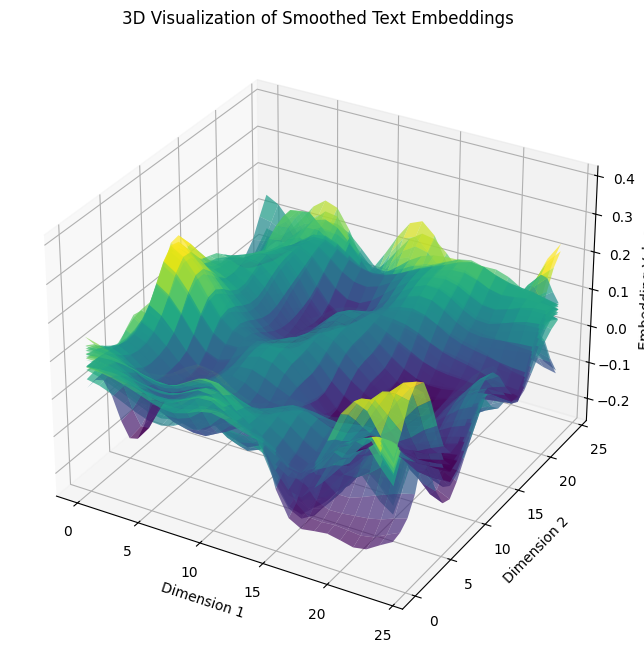

In [10]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

max_input_text_len = 500  # Set a specific maximum length for truncation
min_input_text_len = 10  # Minimum length threshold
layer_index = -1  # Use the last layer by default
scaling_factor = 1.0  # Scaling factor to amplify the embedding values

print("Analyzing ChatGPT Texts")
embedding_chatgpt_list = []
for text in chatgpt_list:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_chatgpt_list.append(embeddings)

embedding_chatgpt_array = np.squeeze(np.array(embedding_chatgpt_list), axis=1)
chatgpt_variance = np.var(embedding_chatgpt_array, axis=0).mean()
print(f"Mean Variance in ChatGPT Embeddings: {chatgpt_variance}")

# Train the autoencoder and visualize embeddings
grid_size = 25
latent_dim = grid_size * grid_size
num_epochs = 100

encoder, decoder, autoencoder = train_autoencoder(embedding_chatgpt_array, latent_dim, num_epochs)

encoded_2d_grid = encoder.predict(embedding_chatgpt_array).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Variance in Encoded Outputs for 'I'm sorry' Data: 0.10724194


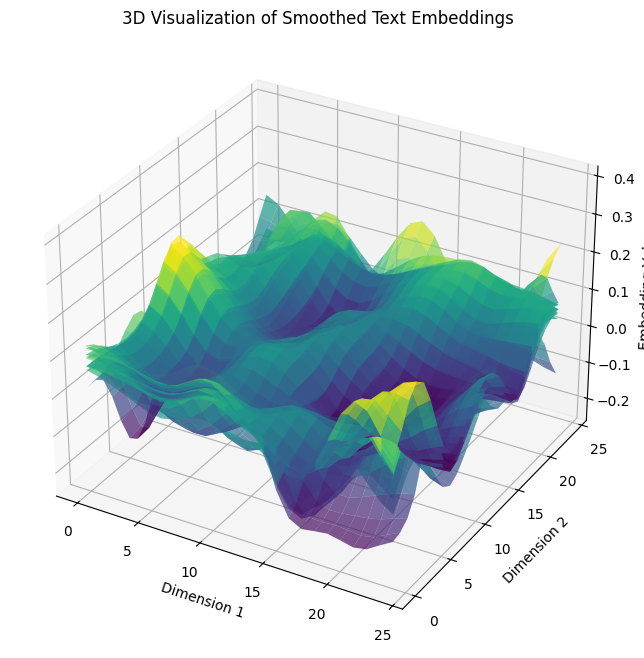

Variance in Encoded Outputs for Non-'I'm sorry' Data: 0.05537934


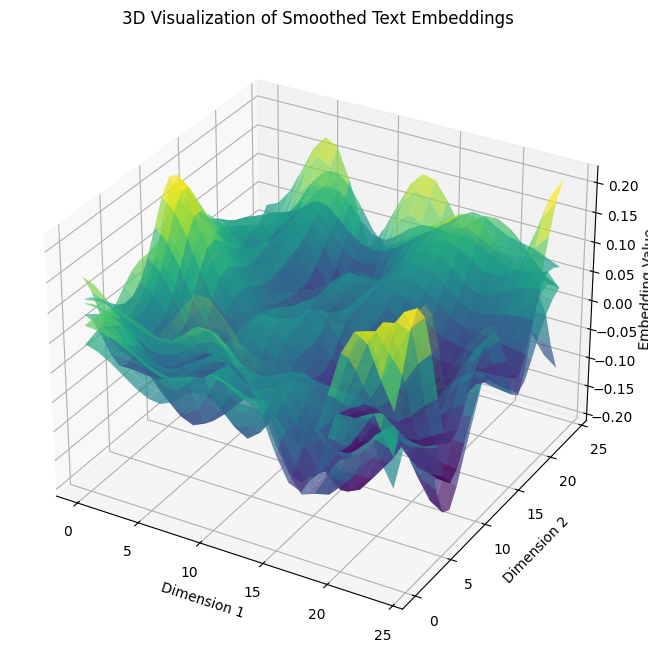

In [11]:
sorry_list = [embedding for text, embedding in zip(chatgpt_list, embedding_chatgpt_list) if "I'm sorry" in text]
non_sorry_list = [embedding for text, embedding in zip(chatgpt_list, embedding_chatgpt_list) if "I'm sorry" not in text]

# Convert lists to arrays
sorry_array = np.squeeze(np.array(sorry_list), axis=1)
non_sorry_array = np.squeeze(np.array(non_sorry_list), axis=1)

# Encode the new arrays using the existing encoder
sorry_encoded_2d_grid = encoder.predict(sorry_array).reshape(-1, grid_size, grid_size)
non_sorry_encoded_2d_grid = encoder.predict(non_sorry_array).reshape(-1, grid_size, grid_size)

# Visualize the split data
print("Variance in Encoded Outputs for 'I'm sorry' Data:", np.var(sorry_encoded_2d_grid, axis=0).mean())
visualize_2d_grid(sorry_encoded_2d_grid, grid_size)

print("Variance in Encoded Outputs for Non-'I'm sorry' Data:", np.var(non_sorry_encoded_2d_grid, axis=0).mean())
visualize_2d_grid(non_sorry_encoded_2d_grid, grid_size)

In [14]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from openai import OpenAI

# Function to get embeddings from OpenAI API
def get_embedding(text, model="text-embedding-3-large"):
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding

max_input_text_len = 500  # Set a specific maximum length for truncation
min_input_text_len = 10  # Minimum length threshold
layer_index = -1  # Use the last layer by default
scaling_factor = 1.0  # Scaling factor to amplify the embedding values

print("Analyzing ChatGPT Texts")
embedding_chatgpt_list = []
for text in chatgpt_list:
    embedding = get_embedding(text)
    if embedding is not None:
        embedding_chatgpt_list.append(embedding)

embedding_chatgpt_array = np.array(embedding_chatgpt_list)
chatgpt_variance = np.var(embedding_chatgpt_array, axis=0).mean()
print(f"Mean Variance in ChatGPT Embeddings: {chatgpt_variance}")

# Train the autoencoder and visualize embeddings
grid_size = 25
latent_dim = grid_size * grid_size
num_epochs = 100

encoder, decoder, autoencoder = train_autoencoder(embedding_chatgpt_array, latent_dim, num_epochs)

encoded_2d_grid = encoder.predict(embedding_chatgpt_array).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)

# Split ChatGPT responses into two lists based on presence of "I'm sorry"
sorry_list = [embedding for text, embedding in zip(chatgpt_list, embedding_chatgpt_list) if "I'm sorry" in text]
non_sorry_list = [embedding for text, embedding in zip(chatgpt_list, embedding_chatgpt_list) if "I'm sorry" not in text]

# Convert lists to arrays
sorry_array = np.array(sorry_list)
non_sorry_array = np.array(non_sorry_list)

# Encode the new arrays using the existing encoder
sorry_encoded_2d_grid = encoder.predict(sorry_array).reshape(-1, grid_size, grid_size)
non_sorry_encoded_2d_grid = encoder.predict(non_sorry_array).reshape(-1, grid_size, grid_size)

# Visualize the split data
print("Variance in Encoded Outputs for 'I'm sorry' Data:", np.var(sorry_encoded_2d_grid, axis=0).mean())
visualize_2d_grid(sorry_encoded_2d_grid, grid_size)

print("Variance in Encoded Outputs for Non-'I'm sorry' Data:", np.var(non_sorry_encoded_2d_grid, axis=0).mean())
visualize_2d_grid(non_sorry_encoded_2d_grid, grid_size)


Analyzing ChatGPT Texts
Mean Variance in ChatGPT Embeddings: 0.00011707112606975994
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.0705
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 0.0121
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 0.0020
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 5.4856e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 3.4932e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 3.7270e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 3.1752e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 3.1242e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 3.0126e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 2.8958e-04
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 2.9422e-04
Epoch 13/100
 8/25 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 2.9311e-04

KeyboardInterrupt: 

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 0.0699
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.0124
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.0022
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 5.0708e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 3.9481e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 3.6721e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 3.3576e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 3.1620e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 4.0098e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 3.5762e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 3.2407e-04
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 2.8967e-04
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 2.7972e-04
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 2.8711e-04
Epoch 16/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 52

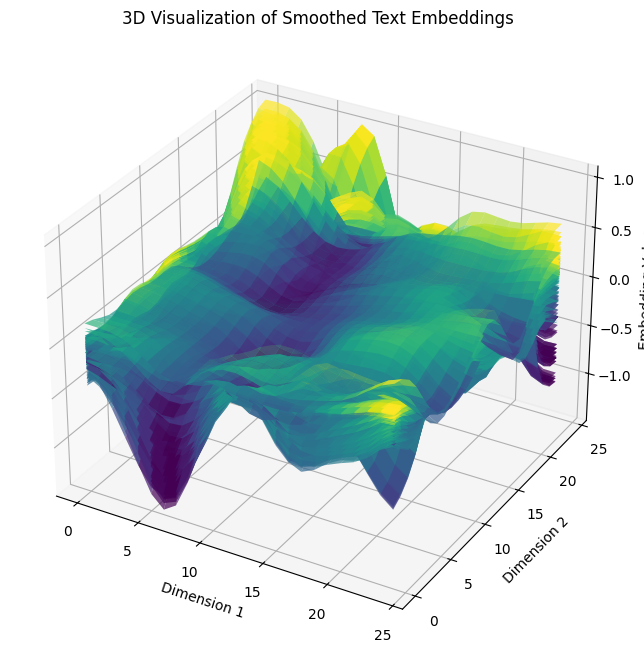

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Variance in Encoded Outputs for 'I'm sorry' Data: 0.5290121


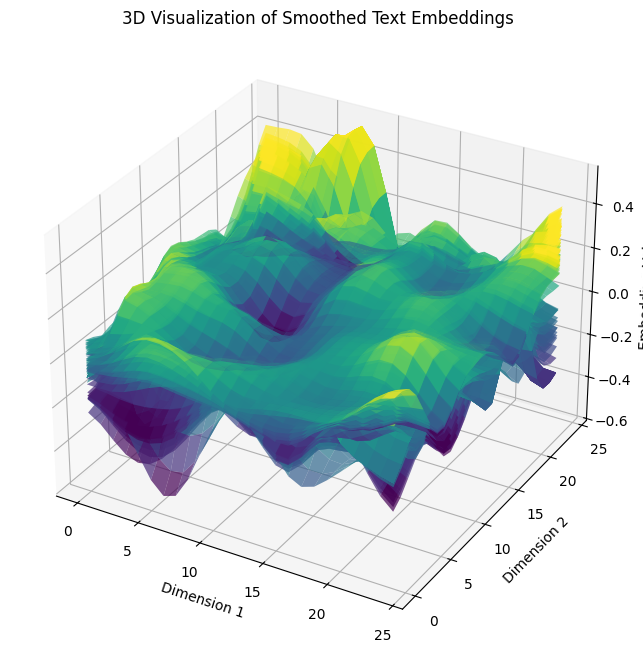

Variance in Encoded Outputs for Non-'I'm sorry' Data: 1.9738644


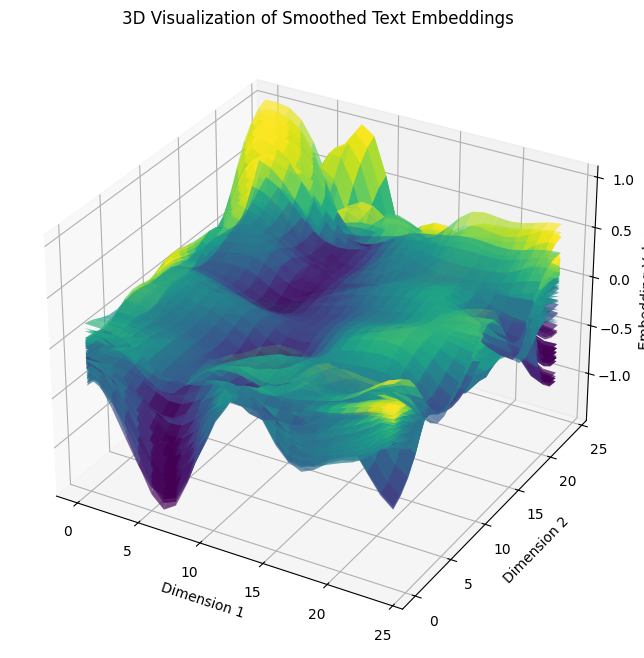

In [15]:

# Train the autoencoder and visualize embeddings
grid_size = 25
latent_dim = grid_size * grid_size
num_epochs = 20

encoder, decoder, autoencoder = train_autoencoder(embedding_chatgpt_array, latent_dim, num_epochs)

encoded_2d_grid = encoder.predict(embedding_chatgpt_array).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)

# Split ChatGPT responses into two lists based on presence of "I'm sorry"
sorry_list = [embedding for text, embedding in zip(chatgpt_list, embedding_chatgpt_list) if "I'm sorry" in text]
non_sorry_list = [embedding for text, embedding in zip(chatgpt_list, embedding_chatgpt_list) if "I'm sorry" not in text]

# Convert lists to arrays
sorry_array = np.array(sorry_list)
non_sorry_array = np.array(non_sorry_list)

# Encode the new arrays using the existing encoder
sorry_encoded_2d_grid = encoder.predict(sorry_array).reshape(-1, grid_size, grid_size)
non_sorry_encoded_2d_grid = encoder.predict(non_sorry_array).reshape(-1, grid_size, grid_size)

# Visualize the split data
print("Variance in Encoded Outputs for 'I'm sorry' Data:", np.var(sorry_encoded_2d_grid, axis=0).mean())
visualize_2d_grid(sorry_encoded_2d_grid, grid_size)

print("Variance in Encoded Outputs for Non-'I'm sorry' Data:", np.var(non_sorry_encoded_2d_grid, axis=0).mean())
visualize_2d_grid(non_sorry_encoded_2d_grid, grid_size)


In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

class AutoEncoderTrainer:
    def __init__(self, encoder_config):
        self.encoder_config = encoder_config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = AutoEncoder(
            input_size=encoder_config['input_size'], 
            hidden_size=encoder_config['hidden_size']
        ).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=encoder_config['learning_rate'])

    def pad_embeddings(self, embeddings):
        max_length = max(len(embedding) for embedding in embeddings)
        padded_embeddings = [self.pad_to_length(embedding, max_length) for embedding in embeddings]
        return np.stack(padded_embeddings)

    def pad_to_length(self, embedding, length):
        padded_embedding = np.zeros(length)
        padded_embedding[:len(embedding)] = embedding
        return padded_embedding

    def train_autoencoder(self, embedding_sets, epochs=10000):
        self.model.train()
        input_tensor = np.array([np.concatenate([self.pad_to_length(embedding, size) for embedding, size in zip(embeddings, self.encoder_config['embedding_sizes'])]) for embeddings in embedding_sets])
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32).to(self.device)
        for epoch in range(epochs):
            encoded, decoded = self.model(input and input_tensor)
            loss = self.criterion(decoded, input_tensor)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
        combined_embedding = encoded.mean(dim=0)
        return combined_embedding.detach().cpu().numpy(), self.model.state_dict()

def main():
    # Define consistent embedding sizes for all inputs
    embedding_sizes = [2000, 1000]  # e.g., sizes from different embedding models
    input_size = sum(embedding_sizes)

    encoder_config = {
        'input_size': input_size,
        'hidden_size': 512,
        'learning_rate': 0.001,
        'embedding_sizes': embedding_sizes  # This keeps track of each model's output size
    }

    trainer = AutoEncoderTrainer(encoder_config)

    # Generate sample embedding sets, each with consistent, predefined sizes
    embedding_sets = [
        [np.random.randint(1000, 4001, size).astype(float) for size in embedding_sizes]
        for _ in range(10)
    ]

    # Train the autoencoder
    combined_embedding, model_weights = trainer.train_autoencoder(embedding_sets)

    # Display the combined embedding and model weights
    print("Combined Embedding:", combined_embedding)
    print("Autoencoder Weights:", model_weights)

if __name__ == "__main__":
    main()


Epoch [10/10000], Loss: 6920477.5000
Epoch [20/10000], Loss: 6920357.0000
Epoch [30/10000], Loss: 6920333.0000
Epoch [40/10000], Loss: 6920297.0000
Epoch [50/10000], Loss: 6920281.5000
Epoch [60/10000], Loss: 6920263.5000
Epoch [70/10000], Loss: 6920251.5000
Epoch [80/10000], Loss: 6920238.0000
Epoch [90/10000], Loss: 6920227.0000
Epoch [100/10000], Loss: 6920221.0000
Epoch [110/10000], Loss: 6920209.5000
Epoch [120/10000], Loss: 6920218.5000
Epoch [130/10000], Loss: 6920199.0000
Epoch [140/10000], Loss: 6920184.5000
Epoch [150/10000], Loss: 6920169.0000
Epoch [160/10000], Loss: 6920165.5000
Epoch [170/10000], Loss: 6920160.5000
Epoch [180/10000], Loss: 6920157.0000
Epoch [190/10000], Loss: 6920151.5000
Epoch [200/10000], Loss: 6920145.0000
Epoch [210/10000], Loss: 6920138.5000
Epoch [220/10000], Loss: 6920124.0000
Epoch [230/10000], Loss: 6920118.0000
Epoch [240/10000], Loss: 6920097.0000
Epoch [250/10000], Loss: 6920082.0000
Epoch [260/10000], Loss: 6920077.5000
Epoch [270/10000], Lo